In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import os
from sklearn.model_selection import train_test_split 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
import matplotlib.pyplot as plt
#import plotly.express as px
import random
#from keras.losses import SparseCategoricalCrossentropy
from collections import Counter
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
def fetch_image(data_folder):
    train_data = []
    test_data = []
    valid_data = []

    splits = {
        "train": os.path.join(data_folder, "train"),
        "test": os.path.join(data_folder, "test"),
        "valid": os.path.join(data_folder, "valid")
    }

    for split_name, split_path in splits.items():
        images_folder = os.path.join(split_path, "images")
        labels_folder = os.path.join(split_path, "labels")

        for image_name in os.listdir(images_folder):
            label_name = os.path.splitext(image_name)[0] + ".txt"
            label_path = os.path.join(labels_folder, label_name)
            image_path = os.path.join(images_folder, image_name)

            if not os.path.exists(label_path):
                print(f"Warning: Label file not found for {image_name}")
                continue

            # Load and preprocess the image
            imgTrafficSignal = Image.open(image_path)
            imgTrafficSignal = imgTrafficSignal.convert("L")  # Convert to grayscale
            img_width, img_height = imgTrafficSignal.size

            with open(label_path, "r") as label_file:
                label_lines = label_file.readlines()
                for line in label_lines:
                    parts = line.strip().split()
                    class_id = int(parts[0])
                    x_center, y_center, width, height = map(float, parts[1:])

                    # Convert normalized bounding box to pixel coordinates
                    x_center_pixel = int(x_center * img_width)
                    y_center_pixel = int(y_center * img_height)
                    width_pixel = int(width * img_width)
                    height_pixel = int(height * img_height)

                    # Calculate the bounding box corners
                    x1 = max(x_center_pixel - width_pixel // 2, 0)
                    y1 = max(y_center_pixel - height_pixel // 2, 0)
                    x2 = min(x_center_pixel + width_pixel // 2, img_width)
                    y2 = min(y_center_pixel + height_pixel // 2, img_height)

                    # Crop the sign area from the image
                    cropped_img = imgTrafficSignal.crop((x1, y1, x2, y2))
                    cropped_img = cropped_img.resize((90, 90))  # Resize to 90x90

                    # Append the cropped image and class ID to the appropriate dataset
                    if split_name == "train":
                        train_data.append((np.array(cropped_img), class_id))
                    elif split_name == "test":
                        test_data.append((np.array(cropped_img), class_id))
                    elif split_name == "valid":
                        valid_data.append((np.array(cropped_img), class_id))

    return train_data, test_data, valid_data

In [3]:
# Example usage
data_folder = "./DataSet"
train_data, test_data, valid_data = fetch_image(data_folder)

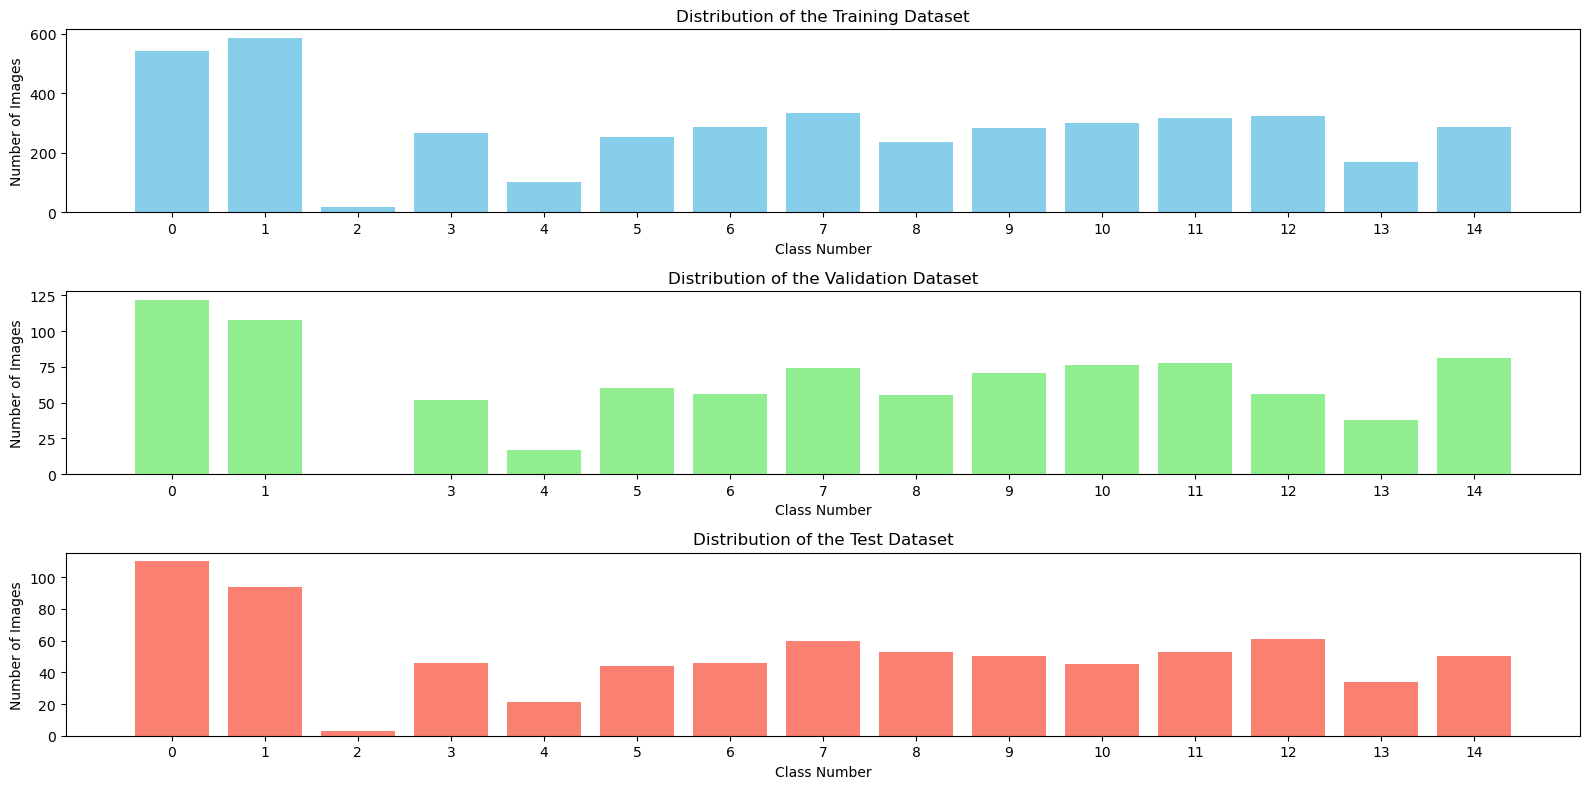

In [4]:
# Count the number of samples per class in each dataset
train_class_counts = Counter(class_id for _, class_id in train_data)
valid_class_counts = Counter(class_id for _, class_id in valid_data)
test_class_counts = Counter(class_id for _, class_id in test_data)

# Sort the counts for consistent visualization
train_classes, train_num_of_samples = zip(*sorted(train_class_counts.items()))
valid_classes, valid_num_of_samples = zip(*sorted(valid_class_counts.items()))
test_classes, test_num_of_samples = zip(*sorted(test_class_counts.items()))

# Plot the distributions for all splits
plt.figure(figsize=(16, 8))

# Training Dataset
plt.subplot(3, 1, 1)
plt.bar(train_classes, train_num_of_samples, color='skyblue')
plt.title("Distribution of the Training Dataset")
plt.xlabel("Class Number")
plt.ylabel("Number of Images")
plt.xticks(train_classes)

# Validation Dataset
plt.subplot(3, 1, 2)
plt.bar(valid_classes, valid_num_of_samples, color='lightgreen')
plt.title("Distribution of the Validation Dataset")
plt.xlabel("Class Number")
plt.ylabel("Number of Images")
plt.xticks(valid_classes)

# Test Dataset
plt.subplot(3, 1, 3)
plt.bar(test_classes, test_num_of_samples, color='salmon')
plt.title("Distribution of the Test Dataset")
plt.xlabel("Class Number")
plt.ylabel("Number of Images")
plt.xticks(test_classes)

# Show the combined plot
plt.tight_layout()
plt.show()


In [5]:
# Create an augmentation generator
augmentation_generator = ImageDataGenerator(
    rotation_range=15,      # Randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # Randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1, # Randomly shift images vertically (fraction of total height)
    brightness_range=[0.8, 1.2],  # Range for brightness adjustment
    zoom_range=0.1,         # Randomly zoom image 
    shear_range=0.1,        # Shear intensity (shear angle in counter-clockwise direction in degrees)
    horizontal_flip=True,   # Randomly flip inputs horizontally
    fill_mode='nearest'     # Strategy for filling in newly created pixels
)

In [6]:
# Modify your data preparation to include augmentation
def augment_data(train_data):
    augmented_features = []
    augmented_labels = []
    
    # Convert train_data to numpy arrays
    train_features, train_labels = zip(*train_data)
    train_features = np.array(train_features)
    train_labels = np.array(train_labels)
    
    # Normalize images
    train_features = train_features / 255.0
    train_features = train_features.reshape(-1, 90, 90, 1)
    
    # Generate augmented images
    for i in range(len(train_features)):
        # Original image
        augmented_features.append(train_features[i])
        augmented_labels.append(train_labels[i])
        
        # Generate augmented versions
        for _ in range(3):  # Create 3 augmented versions of each image
            augmented_img = augmentation_generator.random_transform(train_features[i])
            augmented_features.append(augmented_img)
            augmented_labels.append(train_labels[i])
    
    return list(zip(augmented_features, augmented_labels))

In [7]:
# Apply augmentation to your training data
augmented_train_data = augment_data(train_data)

# Prepare augmented training data
training_data_features, training_data_labels = zip(*augmented_train_data)
training_data_features = np.array(training_data_features)
training_data_labels = np.array(training_data_labels)
training_data_features = training_data_features.reshape(-1, 90, 90, 1)

In [8]:
# Prepare training data features and labels
training_data_features, training_data_labels = zip(*train_data)
training_data_features = np.array(training_data_features)
training_data_labels = np.array(training_data_labels)


training_data_features = training_data_features.astype(np.float32) / 255.0

# Reshape for CNN (add channel dimension)
training_data_features = training_data_features.reshape(-1, 90, 90, 1)

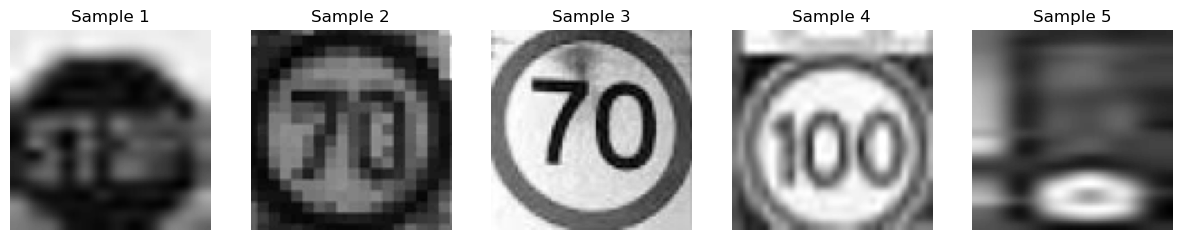

In [9]:
import matplotlib.pyplot as plt
import random

fig, axs = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    random_idx = random.randint(0, len(training_data_features) - 1)
    img = training_data_features[random_idx]

    # Ensure proper scaling to 0-255
    img = (img * 255).astype(np.uint8)

    axs[i].imshow(img, cmap="gray")
    axs[i].axis("off")
    axs[i].set_title(f"Sample {i+1}")

plt.show()


In [10]:
training_data_labels

array([ 7,  7,  7, ..., 14, 14, 14])

In [11]:
cnnModel = Sequential()

# Convolutional Block 1
cnnModel.add(Conv2D(16, (3,3), padding="same", input_shape=(90, 90, 1), activation='relu'))
cnnModel.add(MaxPool2D((2, 2), padding="same"))
cnnModel.add(Dropout(0.2))  # Dropout after the first pooling layer

# Convolutional Block 2
cnnModel.add(Conv2D(32, (3,3), padding="same", activation='relu'))
cnnModel.add(MaxPool2D((2, 2), padding="same"))
cnnModel.add(Dropout(0.2))  # Dropout after the second pooling layer

# Convolutional Block 3
cnnModel.add(Conv2D(64, (5,5), padding="same", activation='relu'))
cnnModel.add(MaxPool2D((2, 2), padding="same"))
cnnModel.add(Dropout(0.3))  # Dropout after third pooling layer

# Convolutional Block 4
cnnModel.add(Conv2D(128, (7,7), padding="same", activation='relu'))
cnnModel.add(MaxPool2D((2, 2), padding="same"))
cnnModel.add(Dropout(0.3))  # Dropout after the fourth pooling layer

# Fully Connected (Dense) Layers
cnnModel.add(Flatten())
cnnModel.add(Dense(232, activation='relu'))
cnnModel.add(Dropout(0.5))  # Dropout after Dense layer to reduce overfitting
cnnModel.add(Dense(116, activation='relu'))
cnnModel.add(Dropout(0.5))  # Dropout after second Dense layer
cnnModel.add(Dense(15, activation='softmax'))

C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
cnnModel.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 90, 90, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 45, 45, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 45, 45, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 23, 23, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 232)            │     1,069,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 232)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 116)            │        27,028 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 116)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │         1,755 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,555,671 (5.93 MB)

 Trainable params: 1,555,671 (5.93 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
from tensorflow.keras.optimizers import Adam

cnnModel.compile(optimizer=Adam(learning_rate=0.0001), 
                 loss='sparse_categorical_crossentropy', 
                 metrics=['accuracy'])


In [14]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,          # Stop training if no improvement for 3 consecutive epochs
    restore_best_weights=True  # Restore the best model weights after stopping
)
# Define the ReduceLROnPlateau callback
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.5,          # Reduce the learning rate by half
    patience=2,          # After 2 epochs of no improvement
    min_lr=1e-6          # Set a lower bound for the learning rate
)


In [15]:
# Prepare validation data
validation_data_features, validation_data_labels = zip(*valid_data)
validation_data_features = np.array(validation_data_features)
validation_data_labels = np.array(validation_data_labels)

# Normalize validation images
validation_data_features = validation_data_features / 255.0
validation_data_features = validation_data_features.reshape(-1, 90, 90, 1)

# Train the model
trafficSignNetwork = cnnModel.fit(
    training_data_features, 
    training_data_labels, 
    validation_data=(validation_data_features, validation_data_labels),
    epochs=40, 
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler]  # Include the callbacks
)

Epoch 1/40
135/135 ━━━━━━━━━━━━━━━━━━━━ 17s 106ms/step - accuracy: 0.1108 - loss: 2.6975 - val_accuracy: 0.1377 - val_loss: 2.6682 - learning_rate: 1.0000e-04
Epoch 2/40
135/135 ━━━━━━━━━━━━━━━━━━━━ 14s 106ms/step - accuracy: 0.1546 - loss: 2.6334 - val_accuracy: 0.2119 - val_loss: 2.5903 - learning_rate: 1.0000e-04
Epoch 3/40
135/135 ━━━━━━━━━━━━━━━━━━━━ 14s 107ms/step - accuracy: 0.1826 - loss: 2.5340 - val_accuracy: 0.2839 - val_loss: 2.3307 - learning_rate: 1.0000e-04
Epoch 4/40
135/135 ━━━━━━━━━━━━━━━━━━━━ 15s 109ms/step - accuracy: 0.2638 - loss: 2.2874 - val_accuracy: 0.3506 - val_loss: 2.0571 - learning_rate: 1.0000e-04
Epoch 5/40
135/135 ━━━━━━━━━━━━━━━━━━━━ 14s 106ms/step - accuracy: 0.3056 - loss: 2.1023 - val_accuracy: 0.3761 - val_loss: 1.9528 - learning_rate: 1.0000e-04
Epoch 6/40
135/135 ━━━━━━━━━━━━━━━━━━━━ 14s 106ms/step - accuracy: 0.3300 - loss: 2.0061 - val_accuracy: 0.4089 - val_loss: 1.8411 - learning_rate: 1.0000e-04
Epoch 7/40
135/135 ━━━━━━━━━━━━━━━━━━━━ 14s 10

KeyboardInterrupt: 

In [ ]:
import seaborn as sns
# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
sns.lineplot(x=list(range(1, len(trafficSignNetwork.history['accuracy']) + 1)),
             y=trafficSignNetwork.history['accuracy'],
             marker='o', label='Training Accuracy')

sns.lineplot(x=list(range(1, len(trafficSignNetwork.history['val_accuracy']) + 1)),
             y=trafficSignNetwork.history['val_accuracy'],
             marker='o', label='Validation Accuracy')

plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
test_data_features, test_data_labels = zip(*test_data)
test_data_features = np.array(test_data_features)
test_data_labels = np.array(test_data_labels)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict the labels on the test data
test_predictions = cnnModel.predict(test_data_features)
# Convert predictions from probabilities to class labels (use argmax to get the index of the highest probability)
test_predictions = np.argmax(test_predictions, axis=1)

# Generate confusion matrix
cm = confusion_matrix(test_data_labels, test_predictions)

# Plot the confusion matrix using seaborn for better visualization
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(test_data_labels), yticklabels=np.unique(test_data_labels))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_data_labels, test_predictions))

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Calculate metrics for each class
for i in range(cm.shape[0]):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp  # sum of the column - TP
    fn = cm[i, :].sum() - tp  # sum of the row - TP
    tn = cm.sum() - (tp + fp + fn)
    
    # Calculate Precision, Recall, F1-Score, and Accuracy
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    print(f"Class {i}:")
    print(f"True Positive (TP): {tp}")
    print(f"False Positive (FP): {fp}")
    print(f"False Negative (FN): {fn}")
    print(f"True Negative (TN): {tn}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print()


In [75]:
cnnModel.save("model_augmented.keras")
